In [1]:
import pandas as pd

In [2]:
# Read in sensor data as dataframe
df_piezo = pd.read_csv('data/Sensor_FieldPRO.csv')
df_piezo.head(2)

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31


In [3]:
# Read in conventional weather station data as dataframe
df_convencional = pd.read_csv('data/Estacao_Convencional.csv')
df_convencional.head(2)

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0


In [4]:
# Transform datetime string column to datetime object
df_piezo['datetime_obj'] = pd.to_datetime(df_piezo['Datetime – utc'], format='ISO8601')
df_convencional['datetime_obj'] = pd.to_datetime(df_convencional['data']+'T'+df_convencional['Hora (Brasília)']+'Z', format='ISO8601')

In [5]:
# Merge the two dataframes (only keep rows with existing data in both input dataframes)
df_combined = df_piezo.merge(df_convencional, on='datetime_obj')

# First step: Leakage current analysis
**First, we need to understand the behaviour of the piezoelectric crystal in the absence of precipitation. It is well-known that a piezoelectric crystal across which is applied an electric field is subject to a leakage current. As a thermodynamic effect, this leakage current should depend exponentially on temperature. We will test this hypothesis below.**

In [6]:
# We will now filter out data that was recorded in temporal proximity to precipitation events at the reference weather station.
# To this end, we start with the set of all indices of the dataframe.
set_of_no_rain_indices = set(df_combined.index.values.tolist())
print(len(set_of_no_rain_indices))

1528


In [7]:
# And remove temporally adjacent datapoints to precipitation events:
rainy_df = df_combined.loc[df_combined['chuva'] > 0.0]
for idx, row in rainy_df.iterrows():
    idx_range = range(idx-5, idx+5)
    for adjacent_idx in idx_range:
        set_of_no_rain_indices.discard(adjacent_idx)
print(len(set_of_no_rain_indices))

1310


In [8]:
# Next, we calculate the decrease of the piezo charge for adjacent dataframe indices and average the rest of the observables.
df_diff = pd.DataFrame(columns=['orig_index','datetime_obj','piezo_charge_decrease','piezo_charge_avg','piezo_temperature','air_humidity_100','air_temperature_100','atm_pressure_main','num_of_resets'], index=['orig_index'])
for idx in set_of_no_rain_indices:
    if {idx-1,idx}.issubset(set_of_no_rain_indices):
        if df_combined.iloc[idx]['num_of_resets'] == df_combined.iloc[idx-1]['num_of_resets']:
            new_row = {'orig_index': idx, 
                       'datetime_obj': df_combined.iloc[idx]['datetime_obj'], 
                       'piezo_charge_decrease': df_combined.iloc[idx-1]['piezo_charge']-df_combined.iloc[idx]['piezo_charge'],
                       'piezo_charge_avg': (df_combined.iloc[idx-1]['piezo_charge']+df_combined.iloc[idx]['piezo_charge'])/2.,
                       'piezo_temperature': (df_combined.iloc[idx]['piezo_temperature']+df_combined.iloc[idx-1]['piezo_temperature'])/2.,
                       'air_humidity_100': (df_combined.iloc[idx]['air_humidity_100']+df_combined.iloc[idx-1]['air_humidity_100'])/2., 
                       'air_temperature_100': (df_combined.iloc[idx]['air_temperature_100']+df_combined.iloc[idx-1]['air_temperature_100'])/2.,
                       'atm_pressure_main': (df_combined.iloc[idx]['atm_pressure_main']+df_combined.iloc[idx-1]['atm_pressure_main'])/2.,
                       'num_of_resets': df_combined.iloc[idx]['num_of_resets']}
            df_diff.loc[idx] = new_row
len(df_diff.index)

1292

<Axes: xlabel='piezo_temperature', ylabel='piezo_charge_decrease'>

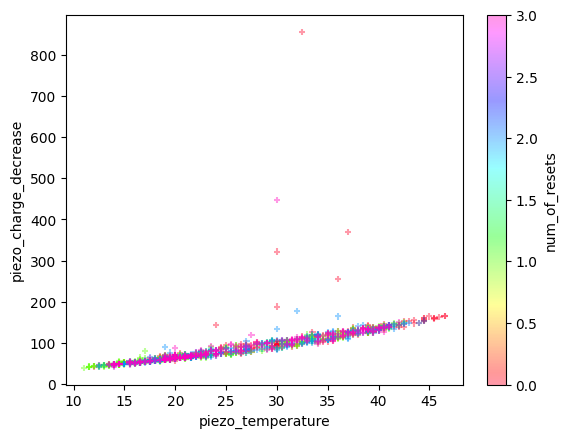

In [9]:
# As expected, the piezo charge decrease depends on the piezo temperature, in a non-linear way. 
# Note that there are still a few outliers contained in the dataset, likely due to precipitation that did not occur at the 
# reference weather station, only at the sensor location.
# Observe that we do not observe a strong dependence of the sensor data on the number of resets. This is good news!
df_diff.plot.scatter(x='piezo_temperature', y='piezo_charge_decrease',c='num_of_resets', cmap='gist_rainbow', alpha=0.4, marker='+')

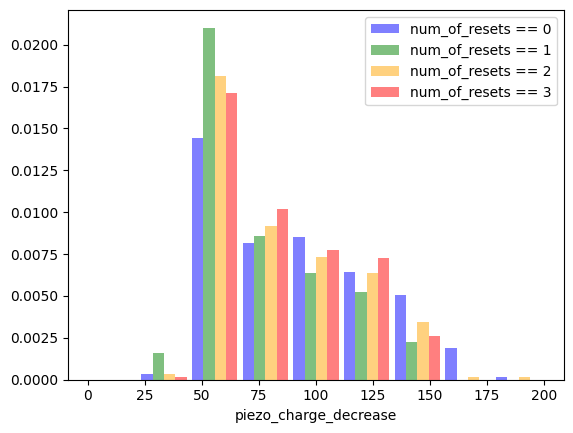

In [10]:
# Let us take another look on the statistical distribution of the piezo charge decrease.
# The histogram supports the hypothesis that there is not any strong dependence on the number of resets of the sensor. 
# This is good news!
import numpy as np
from matplotlib import pyplot as plt
bins = np.linspace(0, 200, 10)
plt.hist([df_diff[df_diff['num_of_resets'] == 0]['piezo_charge_decrease'],df_diff[df_diff['num_of_resets'] == 1]['piezo_charge_decrease'],df_diff[df_diff['num_of_resets'] == 2]['piezo_charge_decrease'],df_diff[df_diff['num_of_resets'] == 3]['piezo_charge_decrease']], bins=bins, color=['blue','green','orange','red'], label=["num_of_resets == 0","num_of_resets == 1","num_of_resets == 2","num_of_resets == 3"], zorder=2, rwidth=0.9, alpha=0.5, density=True)
plt.xlabel('piezo_charge_decrease')
plt.legend(loc='upper right')

In [11]:
# In order to model the piezo charge decrease vs. piezo temperature, we first compute the logarithm of the piezo charge decrease
df_diff['log_piezo_charge_decrease'] = df_diff['piezo_charge_decrease'].map(np.log)

In [12]:
# For this analysis, drop rows with undefined piezo temperature
df_diff.dropna(subset = ['piezo_temperature'], inplace=True)
# For this basic analysis, scipy.stats is sufficient, no need for scikit-learn
from scipy import stats
res = stats.linregress(df_diff['piezo_temperature'].values, df_diff['log_piezo_charge_decrease'].values)
print(f"R-squared: {res.rvalue**2:.6f}")

tinv = lambda p, dfval: abs(stats.t.ppf(p/2, dfval))
ts = tinv(0.01, len(df_diff['piezo_temperature'].values)-2)

print(f"slope (99%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
print(f"intercept (99%): {res.intercept:.6f} +/- {ts*res.intercept_stderr:.6f}")

R-squared: 0.902843
slope (99%): 0.040634 +/- 0.000958
intercept (99%): 3.328721 +/- 0.025738


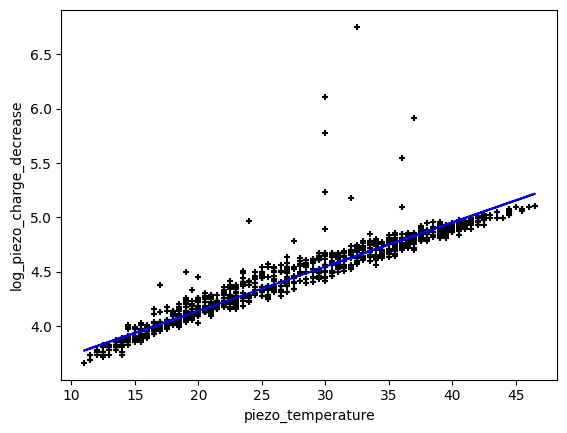

In [13]:
df_diff.plot.scatter(x='piezo_temperature', y='log_piezo_charge_decrease', c='black', marker='+')
plt.plot(df_diff['piezo_temperature'], (res.intercept) + res.slope * (df_diff['piezo_temperature'].values), color='blue')
#plt.plot(df_diff['piezo_temperature'], (res.intercept + ts*res.intercept_stderr) + res.slope * (df_diff['piezo_temperature'].values), color='red')

**Observe that the above data is almost perfectly limited from below by a straight line!**
**The fact that the data is not also limited by a straight line from above can be explained by the fact that the distribution of piezo temperatures is peaked around 20°C and 35°C. The rain and wind events lead to a higher discharge current than the estimated leakage current. Around the peak, more data is available and hence more likely to contain values of discharge current noticeably above the pure leakage current of the piezo crystal.**

array([[<Axes: title={'center': 'piezo_temperature'}>]], dtype=object)

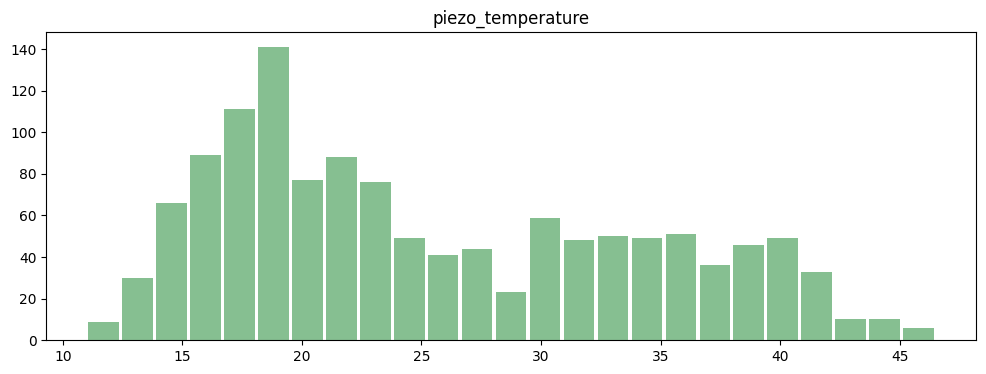

In [14]:
df_diff.hist(column='piezo_temperature', bins=25, grid=False, figsize=(12,4), color='#86bf91', zorder=2, rwidth=0.9)

In [15]:
# To validate our methods, use the linear regression to predict the piezo charge decrease based on the piezo temperature alone
df_diff['piezo_charge_decrease_prediction'] = np.exp((res.intercept) + res.slope * (df_diff['piezo_temperature'].values))

<Axes: xlabel='air_humidity_100', ylabel='piezo_temperature'>

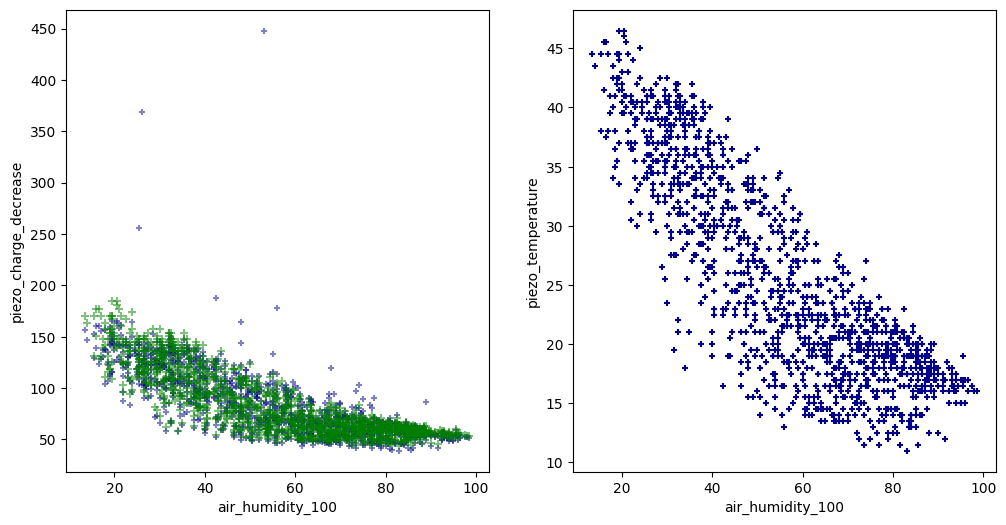

In [16]:
# We also observed that the piezo charge decrease seems to depend on the air humidity.
# However, plotting the actual piezo charge decrease and its prediction, we observe that the dependence is explained by
# the indirect dependence via the correlation of air humidity and piezo temperature (~ roughly ambient temperature)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_diff.plot.scatter(x='air_humidity_100', y='piezo_charge_decrease',c='DarkBlue', marker='+', alpha=0.5, ax=ax1)
ax1.scatter(df_diff['air_humidity_100'].values, df_diff['piezo_charge_decrease_prediction'].values,c='green', marker='+', alpha=0.5)
df_diff.plot.scatter(x='air_humidity_100', y='piezo_temperature',c='DarkBlue', ax=ax2, marker='+')

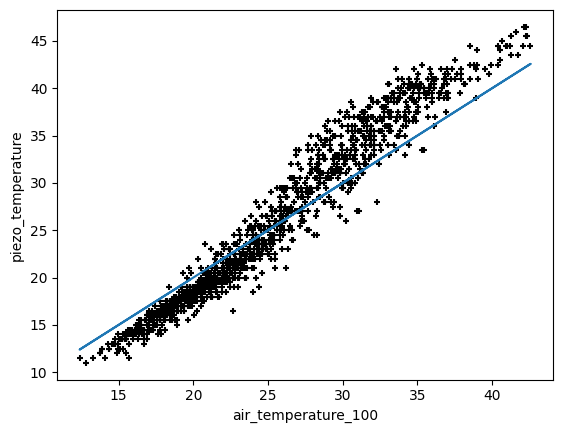

In [17]:
# Not part of this analysis but a curiosity a stumbled upon:
# The piezo temperature is higher than the ambient temperature at high ambient temperatures
# and lower than the ambient temperature at low ambient temperatures.
# It could be interesting to investigate this further, to be sure everything is working as it should.
# Maybe the sun is heating up the sensor housing?
df_diff.plot.scatter(x='air_temperature_100', y='piezo_temperature',c='black', marker='+')
plt.plot(df_diff['air_temperature_100'],df_diff['air_temperature_100'])

# Taking a quick look at the precipitation events...
**After having carried out the leakage current analysis, and before turning to the precipitation estimation model, let us inspect the precipitation events and the related sensor behaviour.**

**To this end, we now apply the above analysis to the entire test period.**

In [18]:
all_indices = df_combined.index.values.tolist()

In [19]:
df_diff_all = pd.DataFrame(columns=['orig_index','datetime_obj','piezo_charge_decrease','piezo_charge_decrease_offset','piezo_charge_avg','piezo_temperature','air_humidity_100','air_temperature_100','atm_pressure_main','num_of_resets','chuva'])
for idx in all_indices:
    if {idx-1,idx}.issubset(all_indices):
        if df_combined.iloc[idx]['num_of_resets'] == df_combined.iloc[idx-1]['num_of_resets']:
            new_row = {'orig_index': idx, 
                       'datetime_obj': df_combined.iloc[idx]['datetime_obj'], 
                       'piezo_charge_decrease': df_combined.iloc[idx-1]['piezo_charge']-df_combined.iloc[idx]['piezo_charge'],
                       'piezo_charge_avg': (df_combined.iloc[idx-1]['piezo_charge']+df_combined.iloc[idx]['piezo_charge'])/2.,
                       'piezo_temperature': (df_combined.iloc[idx]['piezo_temperature']+df_combined.iloc[idx-1]['piezo_temperature'])/2.,
                       'air_humidity_100': (df_combined.iloc[idx]['air_humidity_100']+df_combined.iloc[idx-1]['air_humidity_100'])/2., 
                       'air_temperature_100': (df_combined.iloc[idx]['air_temperature_100']+df_combined.iloc[idx-1]['air_temperature_100'])/2.,
                       'atm_pressure_main': (df_combined.iloc[idx]['atm_pressure_main']+df_combined.iloc[idx-1]['atm_pressure_main'])/2.,
                       'num_of_resets': df_combined.iloc[idx]['num_of_resets'],
                       'chuva': df_combined.iloc[idx]['chuva']}
            df_diff_all.loc[idx] = new_row

In [20]:
# Use the leakage current analysis to predict the piezo charge decrease and calculate the offset between this predicted value
# and the actual observed value
df_diff_all['piezo_charge_decrease_offset'] = df_diff_all['piezo_charge_decrease']-df_diff_all['piezo_temperature'].map(lambda x: np.exp(res.intercept + res.slope * x))
df_diff_all[['datetime_obj','piezo_charge_decrease_offset','chuva']].head(2)

,datetime_obj,piezo_charge_decrease_offset,chuva
1,2020-10-01 00:00:00+00:00,1.642061,0.0
2,2020-10-01 01:00:00+00:00,3.664315,0.0


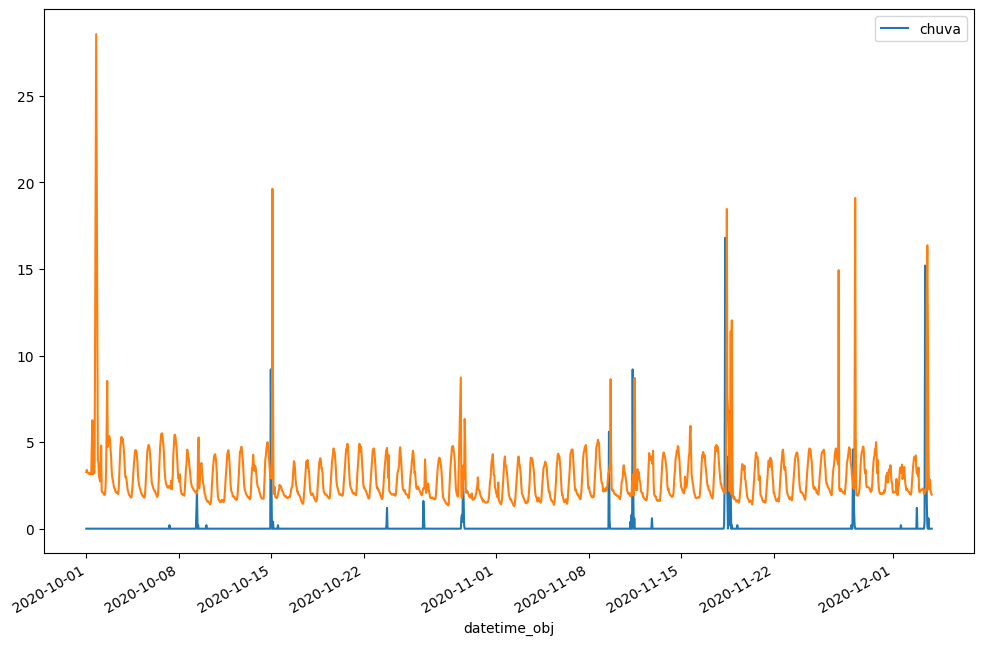

In [21]:
# First, plot the untreated value of the piezo charge decrease vs the precipitation at the reference station:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease"]/30) #factor 30 just as a guess to bring to similar scale
# Observe that the piezo charge decrease oscillates with a period of a day (night-day temperature fluctuation)

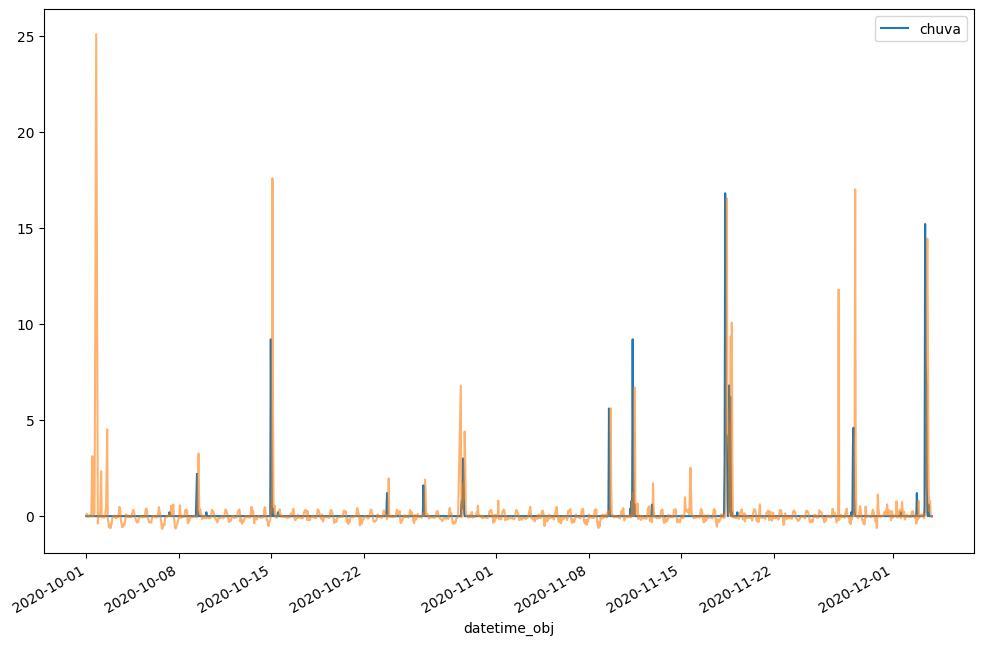

In [22]:
# As soon as we subtract the predicted piezo charge decrease value, most of the fluctuation disappears.
# And the precipitation events become more visible in the sensor data.
# Observe that the first big peak in the sensor data has no representation in the data of the reference station.
# This suggests a localized precipitation event at the location of the sensor that did not occur at the reference station.
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30, alpha=0.6) #factor 30 just as a guess to bring to similar scale

**Below, we shortly plot all of the major precipitation events in more detail.**

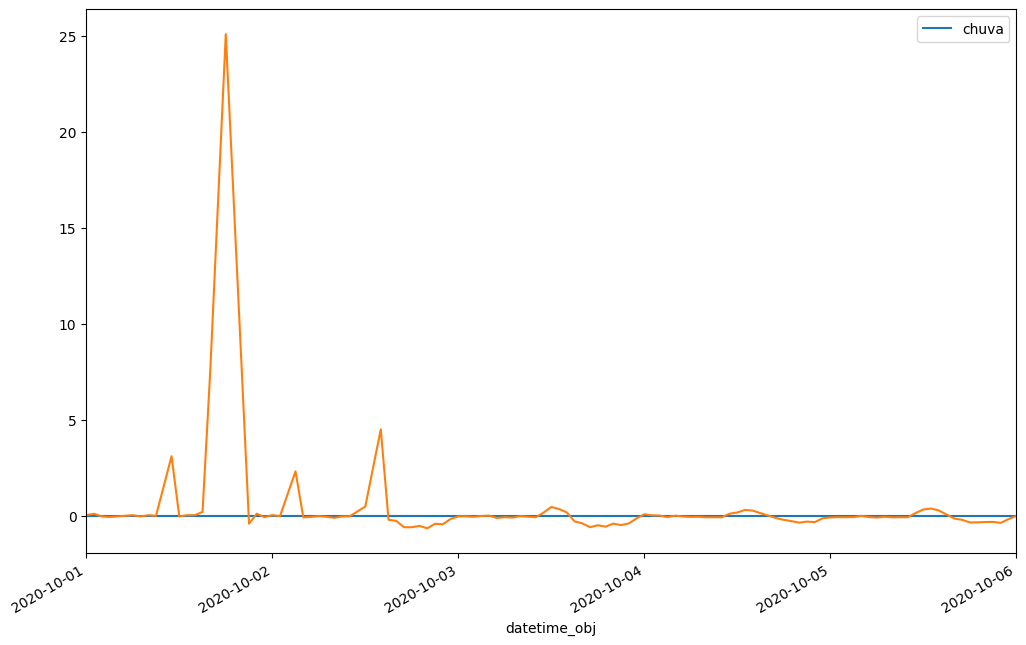

In [23]:
# First, the unmatched precipitation event at the sensor location:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-10-01'), pd.Timestamp('2020-10-06'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

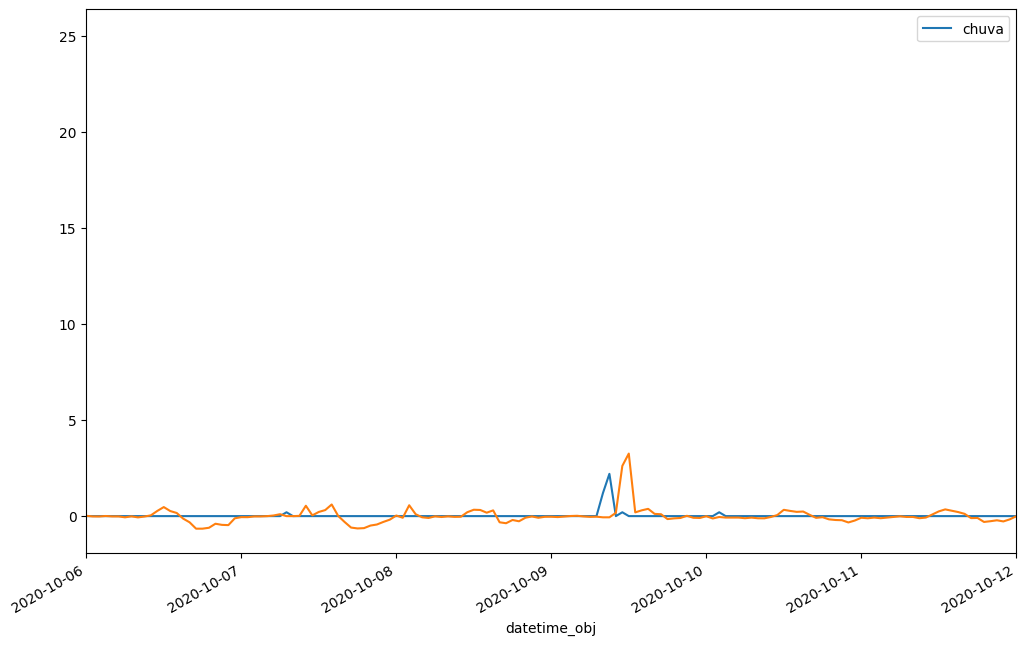

In [24]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-10-06'), pd.Timestamp('2020-10-12'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

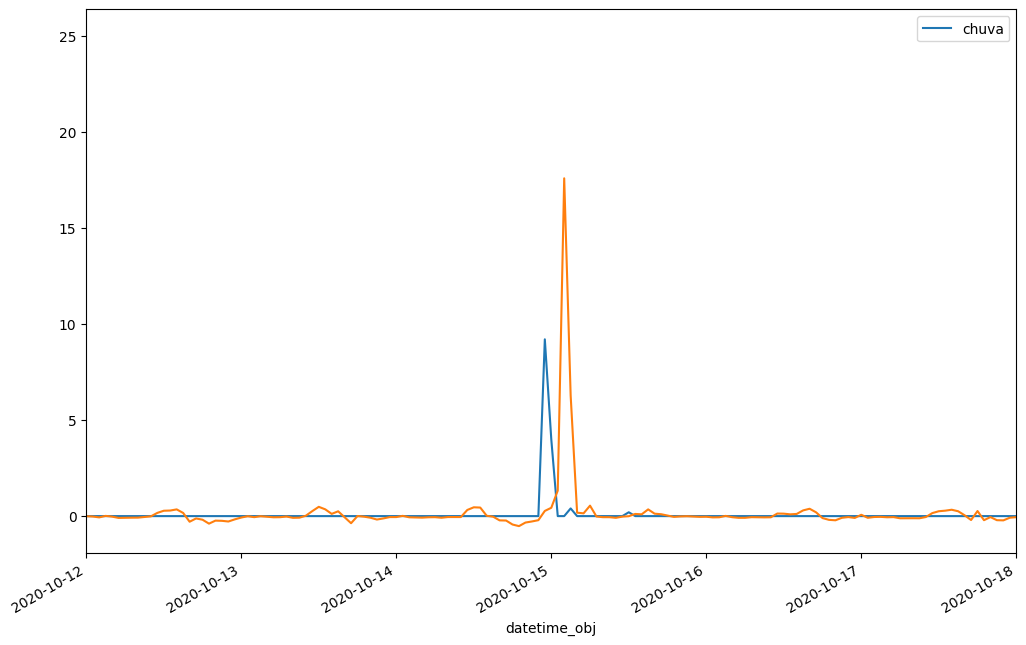

In [25]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-10-12'), pd.Timestamp('2020-10-18'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

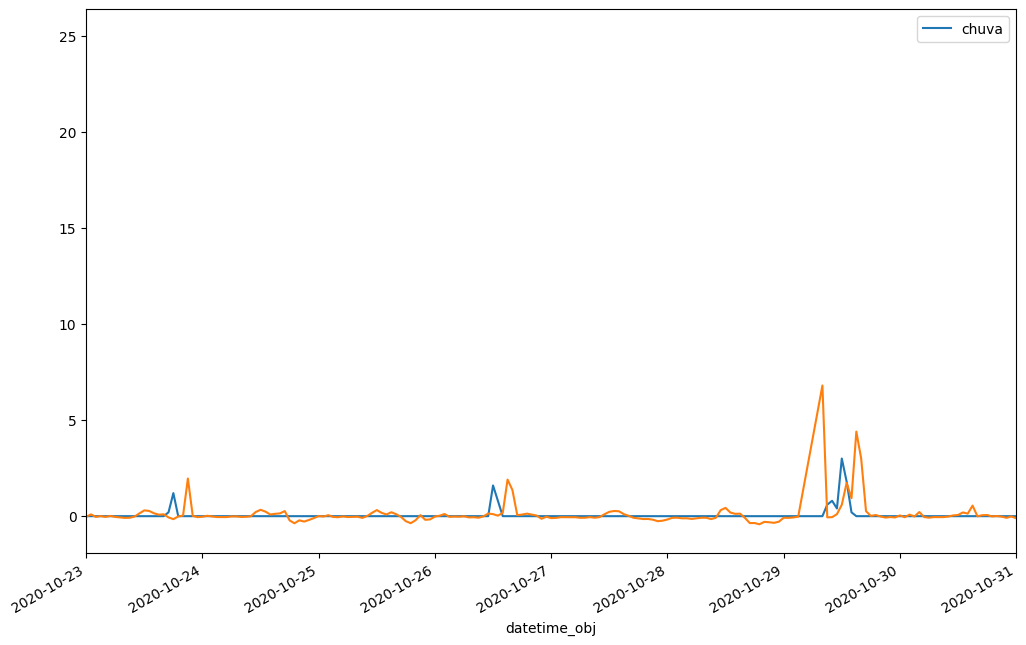

In [26]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-10-23'), pd.Timestamp('2020-10-31'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

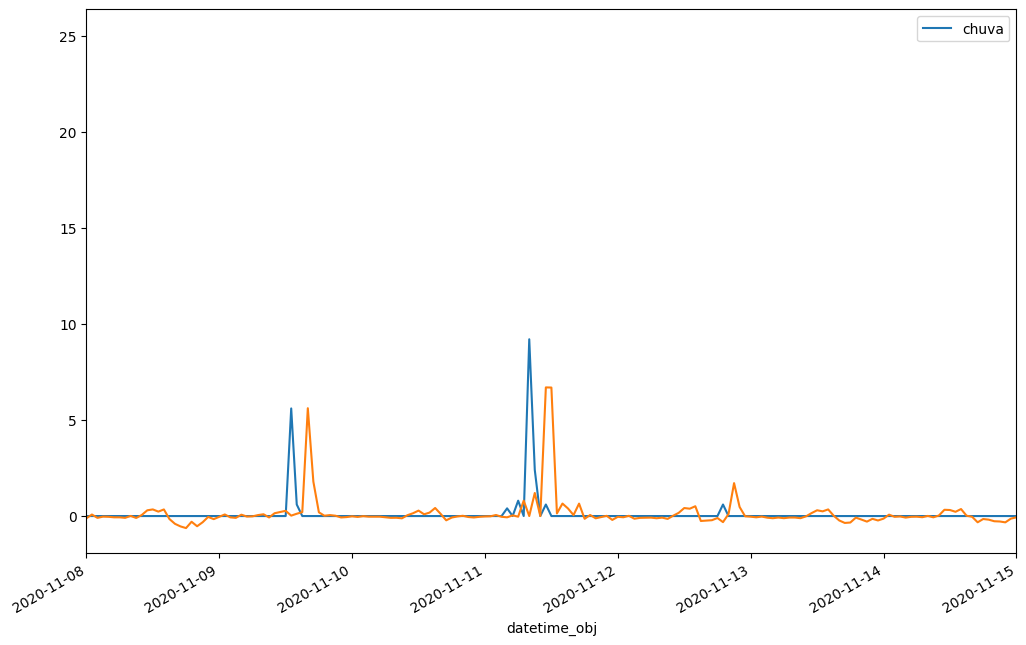

In [27]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-11-08'), pd.Timestamp('2020-11-15'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

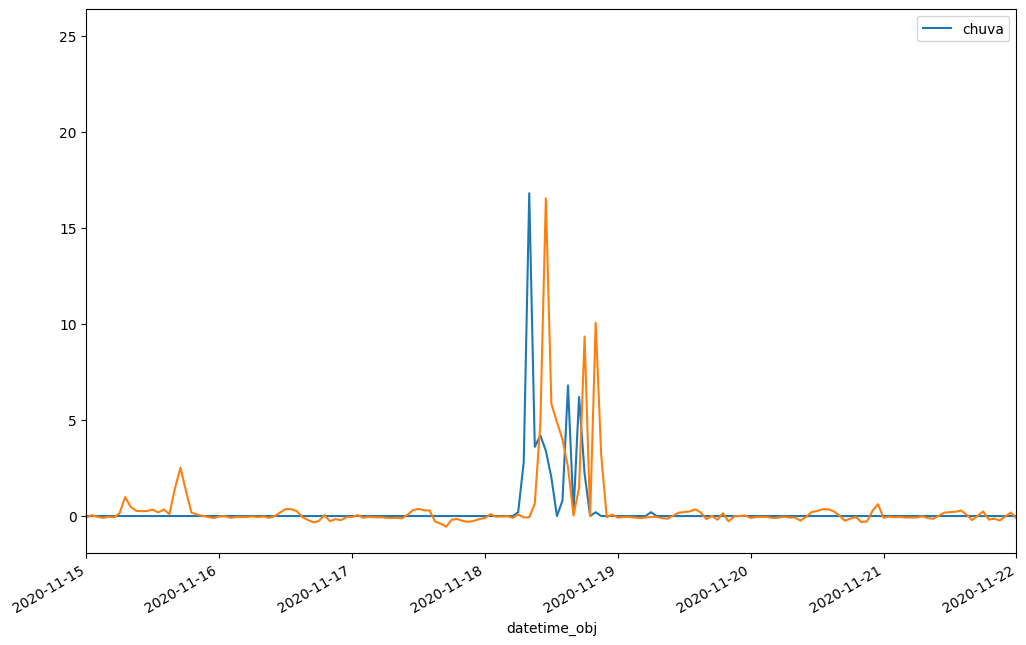

In [28]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-11-15'), pd.Timestamp('2020-11-22'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

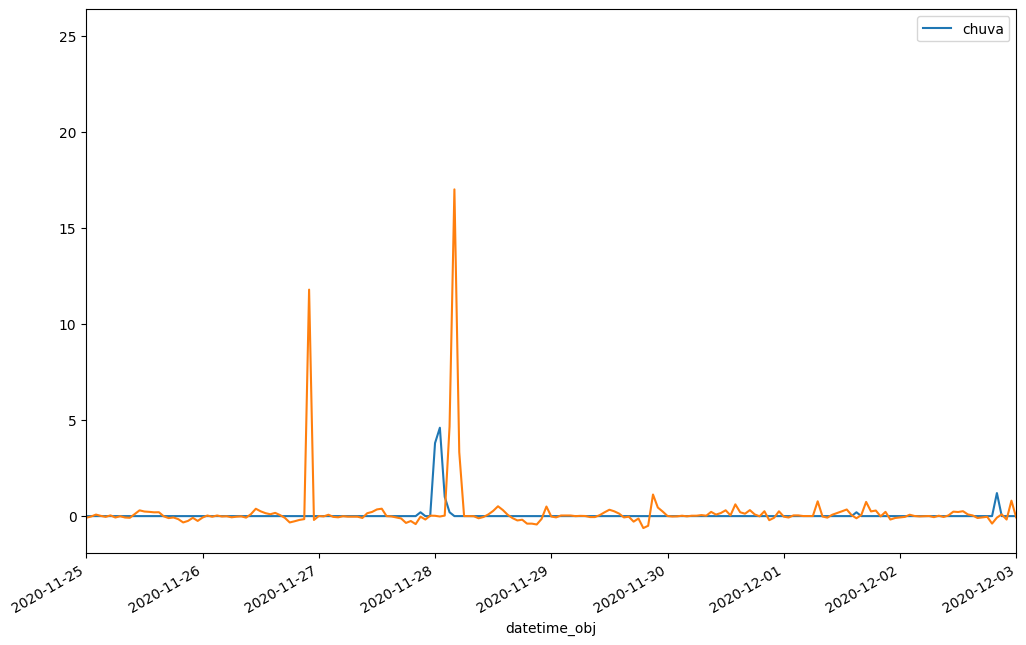

In [29]:
ax = df_diff_all.plot(x="datetime_obj", y="chuva", figsize=(12,8))
ax.set_xlim(pd.Timestamp('2020-11-25'), pd.Timestamp('2020-12-03'))
ax.plot(df_diff_all["datetime_obj"], df_diff_all["piezo_charge_decrease_offset"]/30)

# Towards the precipitation estimation model
**After having completed the leakage current analysis and have looked at the precipitation events, we now can head on to quantify precipitation using the piezo-electric sensor.**

**Fitting a complex model on a big collection of this type of data, is quite an interesting example of how data science can generate usable output data from a simple device, taking into account other environmental variables in order make the prediciton more precise, at least in average.**

<span style="color:red">**Unfortunately, 11 precipitation events are not enough for us to able to fit a multidimensional model. So instead, we will leave the data science tools for a later moment where we can work with a much bigger dataset. For the moment, we turn to hard science methods to do the best with the little data provided. Our objective here cannot be precision and instead must be robustness of our model.**</span>

In [30]:
# As a first step of this analysis, we use the "set_of_no_rain_indices" in order to seperate the precipitation events into pieces.
# In order to consider two precipitation events as one, the may not be separated by more than 10 hours.
set_of_rainy_indices = set(df_combined.index.values.tolist()).difference(set_of_no_rain_indices)
sorted_list_of_rain_indices = sorted(set_of_rainy_indices)
intervals = []
current = sorted_list_of_rain_indices[0]
while current <= sorted_list_of_rain_indices[-1]:
    while current not in sorted_list_of_rain_indices and current <= sorted_list_of_rain_indices[-1]:
        current += 1
    init = current
    while current in sorted_list_of_rain_indices:
        current += 1
    end = current-1
    intervals.append((init, end))

In [31]:
# In fact, in this way we find 15 precipitation events, of which some sum a very small total precipitation.
intervals

[(142, 151),
 (191, 203),
 (209, 218),
 (326, 348),
 (536, 546),
 (603, 613),
 (668, 682),
 (936, 946),
 (975, 991),
 (1014, 1023),
 (1145, 1178),
 (1376, 1391),
 (1466, 1475),
 (1495, 1504),
 (1509, 1525)]

In [32]:
# Now we calculate the total precipitation for each precipitation event for the reference station
# and calculate the sum of the piezo charge decrease offset.
rain_event_piezo_charge_decrease_offset = []
rain_event_chuva = []
for interval in intervals:
    sum = df_diff_all[['piezo_charge_decrease_offset','chuva']].iloc[interval[0]:interval[1]+1].sum()
    rain_event_piezo_charge_decrease_offset.append(sum['piezo_charge_decrease_offset'])
    rain_event_chuva.append(sum['chuva'])

Text(0, 0.5, 'total piezo charge decrease offset')

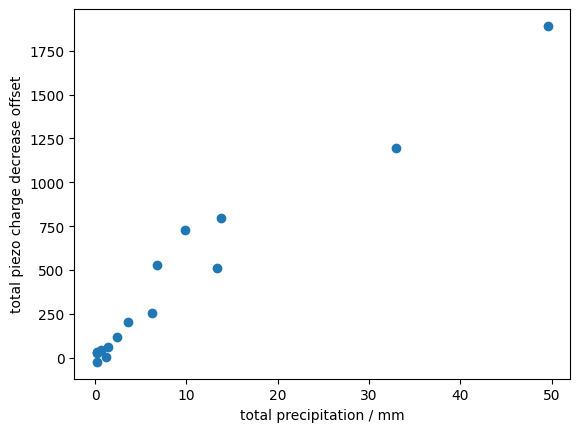

In [33]:
# We can now plot the total piezo charge decrease offset vs. the total precipitation of the reference station
plt.scatter(rain_event_chuva, rain_event_piezo_charge_decrease_offset)
plt.xlabel('total precipitation / mm')
plt.ylabel('total piezo charge decrease offset')
# It suggests a linear regression, as expected.

In [34]:
# Hence we carry out a least squared linear regression with scipy
# It may be worth thinking about a reasonable way to weight our samples. Here, I decided not to attribute weights to the samples.
from scipy import stats
rain_res = stats.linregress(rain_event_chuva, rain_event_piezo_charge_decrease_offset)
print(f"R-squared: {rain_res.rvalue**2:.6f}")

R-squared: 0.945560


In [35]:
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(rain_event_chuva)-2)

print(f"slope (95%): {rain_res.slope:.6f} +/- {ts*rain_res.stderr:.6f}")

print(f"intercept (95%): {rain_res.intercept:.6f} +/- {ts*rain_res.intercept_stderr:.6f}")
# The value of the intercept agrees with null hypothesis that zero piezo charge decrease offset corresponds to zero precipitation.

slope (95%): 37.522619 +/- 5.394651
intercept (95%): 69.411576 +/- 89.432840


Text(0, 0.5, 'total piezo charge decrease offset')

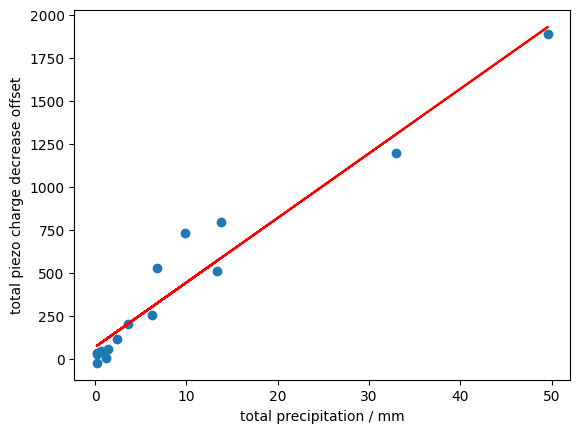

In [36]:
plt.scatter(rain_event_chuva, rain_event_piezo_charge_decrease_offset)
plt.plot(rain_event_chuva, rain_res.intercept + rain_res.slope * np.array(rain_event_chuva), color='red')
plt.xlabel('total precipitation / mm')
plt.ylabel('total piezo charge decrease offset')

# Comments about the precipitation estimation model

**Due to fact that we only have a few rain events at hand and comparison data is only available from a *nearby* weather station (not immediately next to the sensor), we have to prefer robustness over precision. If more data were available from various different sensors with various different comparison data over a long period of time, we could employ more complex models that then could predict the precipitation with much more precision, also taking into account the other environmental variables such as air temperature, relative air humidity and atmospheric pressure.**

**A large dataset also has the advantage that we could carry out a proper separation of the dataset into a training and validation dataset, other than allowing cross-validation. Methods, that allow us to fit a large, flexible model without overfitting.**

**In this case however, it is better to deliver a robust algorithm that translates the sensor data into an estimate for the precipitation. Linear regression is the most robust such algorithm at our hand for the small dataset that we have available.**

**Here, the available data biased our linear regression towards underestimating small precipitation events. Which should be regarded as the desired behaviour for our small dataset, since we avoid falsely reporting rain events when there is, in fact, blue sky. In the agricultural setting, it is particularly important to identify big rain events correctly and to estimate the accumulated precipitation quantity correctly over a period of weeks and months.**

In [37]:
# Unconventional hack to format the precipitation prediction column. For production worth to reconsider:
df_diff_all['precipitation_prediction'] = np.abs(round((df_diff_all['piezo_charge_decrease_offset']-rain_res.intercept)/rain_res.slope,2) * np.heaviside((df_diff_all['piezo_charge_decrease_offset']-rain_res.intercept)/rain_res.slope, 1))

In [38]:
# Finally save the dataframe for consultation at a later point in time:
df_diff_all.to_csv('data/calibration_result.csv')  

In [39]:
# Next, we calculate the decrease of the piezo charge for adjacent dataframe indices and average the rest of the observables.
df_diff_predict = pd.DataFrame(columns=['orig_index','datetime_obj','piezo_charge_decrease','piezo_charge_avg','piezo_temperature','air_humidity_100','air_temperature_100','atm_pressure_main','num_of_resets'])
for idx in df_piezo.index.values.tolist():
    if {idx-1,idx}.issubset(set(df_piezo.index.values.tolist())):
        if df_piezo.iloc[idx]['num_of_resets'] == df_piezo.iloc[idx-1]['num_of_resets']:
            new_row = {'orig_index': idx, 
                       'datetime_obj': df_piezo.iloc[idx]['datetime_obj'], 
                       'piezo_charge_decrease': df_piezo.iloc[idx-1]['piezo_charge']-df_piezo.iloc[idx]['piezo_charge'],
                       'piezo_charge_avg': (df_piezo.iloc[idx-1]['piezo_charge']+df_piezo.iloc[idx]['piezo_charge'])/2.,
                       'piezo_temperature': (df_piezo.iloc[idx]['piezo_temperature']+df_piezo.iloc[idx-1]['piezo_temperature'])/2.,
                       'air_humidity_100': (df_piezo.iloc[idx]['air_humidity_100']+df_piezo.iloc[idx-1]['air_humidity_100'])/2., 
                       'air_temperature_100': (df_piezo.iloc[idx]['air_temperature_100']+df_piezo.iloc[idx-1]['air_temperature_100'])/2.,
                       'atm_pressure_main': (df_piezo.iloc[idx]['atm_pressure_main']+df_piezo.iloc[idx-1]['atm_pressure_main'])/2.,
                       'num_of_resets': df_piezo.iloc[idx]['num_of_resets']}
            df_diff_predict.loc[idx] = new_row
len(df_diff_predict.index)

1707

In [40]:
# Once more calculate the piezo charge decrease offset
df_diff_predict['piezo_charge_decrease_offset'] = df_diff_predict['piezo_charge_decrease']-df_diff_predict['piezo_temperature'].map(lambda x: np.exp(res.intercept + res.slope * x))

In [41]:
# Unconventional hack to format the precipitation prediction column. For production worth to reconsider:
df_diff_predict['precipitation_prediction'] = (df_diff_predict['piezo_charge_decrease_offset']-rain_res.intercept)/rain_res.slope
df_diff_predict['precipitation_prediction'] = df_diff_predict['precipitation_prediction'].map(lambda x: round(x,2) if x > 0 else 0)

In [42]:
# Finally save the dataframe for consultation at a later point in time:
df_diff_predict.to_csv('data/prediction_result.csv')  